# Predicting Heart Disease

## Score: .95304

In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

DATA_DIR = Path("playground-series-s6e2")
OUTPUT_DIR = Path(".")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [27]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
train.head()

Train: (630000, 15)
Test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [28]:
target_col = "Heart Disease"
id_col = "id"
feature_cols = [c for c in train.columns if c not in (id_col, target_col)]

le = LabelEncoder()
y = le.fit_transform(train[target_col])

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

for col in feature_cols:
    if X_train[col].isna().any() or X_test[col].isna().any():
        med = X_train[col].median()
        X_train[col] = X_train[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

X_train["chol_exercise"] = X_train["Cholesterol"] * X_train["Exercise angina"]
X_test["chol_exercise"] = X_test["Cholesterol"] * X_test["Exercise angina"]

scaler_feat = StandardScaler()
X_tr_s = scaler_feat.fit_transform(X_train)
X_te_s = scaler_feat.transform(X_test)
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
kmeans.fit(X_tr_s)
for i in range(kmeans.n_clusters):
    d_tr = np.linalg.norm(X_tr_s - kmeans.cluster_centers_[i], axis=1)
    d_te = np.linalg.norm(X_te_s - kmeans.cluster_centers_[i], axis=1)
    X_train[f"dist_c{i}"] = d_tr
    X_test[f"dist_c{i}"] = d_te

print(f"Features: {len(X_train.columns)} columns")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

Features: 26 columns
Target distribution: {0: 347546, 1: 282454}


In [29]:
depth, lr = 5, 0.04
n_est = 800

In [30]:
_imp = cb.CatBoostClassifier(iterations=n_est, depth=depth, learning_rate=lr, min_data_in_leaf=25, subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0).fit(X_train, y)
imp = _imp.get_feature_importance()
top2_cols = X_train.columns[np.argsort(imp)[-2:]].tolist()
X_train[top2_cols] *= 2
X_test[top2_cols] *= 2

model = cb.CatBoostClassifier(iterations=n_est, depth=depth, learning_rate=lr, min_data_in_leaf=25, subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
oof = cross_val_predict(model, X_train, y, cv=cv, method="predict_proba")[:, 1]
print(f"CV AUC: {roc_auc_score(y, oof):.5f}")

CV AUC: 0.95498


In [31]:
model.fit(X_train, y)
test_proba = model.predict_proba(X_test)[:, 1]

In [32]:
pass

Confusion matrix (OOF, threshold=0.5)
Rows: true, Cols: predicted |  Absence   Presence
[[314989  32557]
 [ 37832 244622]]


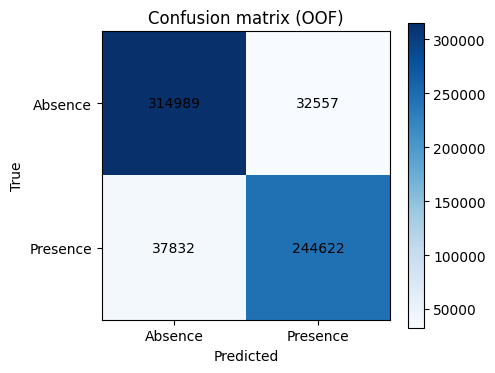

In [33]:
y_pred = (oof >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)
print("Confusion matrix (OOF, threshold=0.5)")
print("Rows: true, Cols: predicted |  Absence   Presence")
print(cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Absence", "Presence"])
plt.yticks([0, 1], ["Absence", "Presence"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.title("Confusion matrix (OOF)")
plt.tight_layout()
plt.show()

In [34]:
sub = pd.DataFrame({"id": test["id"], "Heart Disease": test_proba})
sub.to_csv(OUTPUT_DIR / "submission.csv", index=False)
print(f"Submission saved to {OUTPUT_DIR / 'submission.csv'}")
sub.head(10)

Submission saved to submission.csv


,id,Heart Disease
0,630000,0.949296
1,630001,0.006215
2,630002,0.990075
3,630003,0.003389
4,630004,0.209021
5,630005,0.987004
6,630006,0.004785
7,630007,0.687700
8,630008,0.992272
9,630009,0.013200
